In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand


In [2]:
width = 823
length = 1190
center = 640


# хорошим алгоритмом будет стремление к центру при любом ударе

# будем считать что отсчет координат у каждой из сторон свой,
# т.е. нижний левый и правый верхний углы корта являются точками (0,0)

In [3]:
class Agent:
    def __init__(self, n, l, r):
        # количество квадратов (с каждой стороны)
        self.n = n
        self.step_w = width / n
        self.step_l = length / n
        
        self.l = l
        self.r = 2*r ## это важно !!!
        self.x = width/2
        self.y = 0

    def on_position(self):
        self.x = width/2
        self.y = 0
    
    def coords(self):
        return self.x, self.y
    
    def hit(self, x, y, f):
        if f:
            # подаем всегда в левый ближний угол (от себя)
            return (rand()*self.step_w + width-self.step_w, rand()*self.step_l + length-self.step_l)
        # отбиваем в дальний от бота квадрат
        # углы - 0: ЛН, 1: ПН; 2: ПВ; 3: ЛВ
        t = np.argmax([
            np.linalg.norm([x,y]), 
            np.linalg.norm([width-x,y]), 
            np.linalg.norm([width-x,length-y]), 
            np.linalg.norm([x,length-y])])
        
        x_new = rand() * self.step_w + (width-self.step_w)*int(t in [1,2])
        y_new = rand() * self.step_l + (length-self.step_l)*int(t in [2,3])
        
        # 5% шанс попасть в другой квадрат или аут
        if rand() < 0.05:
            fl = [-1, 1][int(rand() > 0.5)]
            if rand() > 0.5:
                x_new += fl * self.step_w
            else:
                y_new += fl * self.step_l
        
        # print(t)
        # проверяем на попадание в аут и возвращаем координаты мяча 
        return  ((0 <= x_new <= width) and (0 <= y_new <= length), x_new, y_new)
        
    
    def take_ball(self, x, y):
        # т.к. отбиваем по полуокружности, надо отбежать
        if y < self.y:
            if x > self.x:
                x = max(x-self.r, self.x)
            else:
                x = min(x+self.r, self.x)
            
            if ((self.y - y)**2 + (self.x - x)**2)**0.5 > self.l:
                return False
            else:
                self.y = y
                self.x = x
                return True
        else:
            v = np.array([x-self.x, y-self.y])
            norm = np.linalg.norm(v)
            # print("Norm:",  norm)
            if norm > self.l+self.r:
                return False
            else:
                # двигаемся к ближайшей точке для отбития
                if norm > self.r:
                    v = (norm-self.r)*(v / norm)
                    self.x += v[0]
                    self.y += v[1]
                return True
    
    def __str__(self):
        return f"Agent ({self.x}, {self.y})"
        

In [4]:
class Bot:
    # его тактика - добегать до мяча "вплотную"
    def __init__(self, l, r):
        
        self.l = l
        self.r = r
        self.x = width/2
        self.y = length-center

    def on_position(self):
        self.x = width/2
        self.y = length-center
    
    def coords(self):
        return self.x, self.y
    

    def hit(self):
        return (rand()*width, rand()*length)
    
    def take_ball(self, x, y):
        v = np.array([x-self.x, y-self.y])
        norm = np.linalg.norm(v)
        if norm > self.l+self.r:
            return False
        # двигаемся ближе к мячу для отбития
        if norm > self.r:
            v = self.l*(v / norm)
            self.x += v[0]
            self.y += v[1]
        return True

    def __str__(self):
        return f"Bot ({self.x}, {self.y})"

In [5]:
l = 100
r = 100
n = 2

bot = Bot(l,r)
agent = Agent(n,l,r)

# print(bot)
# print(agent)
# print()


def game(agent, bot):
    c1, c2 = 0, 0
    f = True
    t = None
    while (c1 < 4 and c2 < 4) or abs(c1-c2) < 2:
        if f:
            agent.on_position()
            bot.on_position()
            t = agent.hit(*bot.coords(), f)
            if not bot.take_ball(*t):
                c1 += 1
                f = True
                continue
            t = bot.hit()
            f = False
        
        if not agent.take_ball(*t):
            c2 += 1
            f = True
            continue

        t = agent.hit(*bot.coords(), f)
        if not t[0]:
            c2 += 1
            f = True
            continue
        
        if not bot.take_ball(t[1], t[2]):
            c1 += 1
            f = True
            continue
        
        t = bot.hit()
    return c1, c2


# для тестирования

# s1, s2 = 0, 0
# for s in range(1, 4):
#     print(f"Set {s}")
#     g1, g2 = 0, 0
#     j = 0
#     while (g1 < 6 and g2 < 6) or abs(g1-g2) < 2:
#         j += 1
#         c1, c2 = game(agent, bot)
#         print(f"    Game {j}: {c1} - {c2} ")
#         if c1 > c2:
#             g1 += 1
#         else:
#             g2 += 1
    
#     s1 += g1 > g2
#     s2 += g1 < g2

# print(s1, s2)
# print(f"Агент {['проиграл', 'победил'][int(s1 > s2)]}")




In [6]:
def play_match(agent, bot):
    s1, s2 = 0, 0
    for s in range(1, 4):
        # print(f"Set {s}")
        g1, g2 = 0, 0
        j = 0
        while (g1 < 6 and g2 < 6) or abs(g1-g2) < 2:
            j += 1
            c1, c2 = game(agent, bot)
            # print(f"    Game {j}: {c1} - {c2} ")
            if c1 > c2:
                g1 += 1
            else:
                g2 += 1
        
        s1 += g1 > g2
        s2 += g1 < g2
    return s1 > s2

In [44]:
d = []
for n in range(2, 10):
    for l in range(300, 501, 20):
        for r in range(300, 501, 20):
            agent = Agent(n,l,r)
            bot = Bot(l, r)
            s = 0
            k = 10
            for j in range(k):
                s += play_match(agent, bot)
            d.append((n, l, r, s/k))


In [45]:
import pandas as pd

res = pd.DataFrame(d, columns=['n', 'l', 'r', 'res'])

In [46]:
res

,n,l,r,res
0,2,300,300,1.0
1,2,300,320,1.0
2,2,300,340,1.0
3,2,300,360,1.0
4,2,300,380,1.0
...,...,...,...,...
963,9,500,420,1.0
964,9,500,440,1.0
965,9,500,460,1.0
966,9,500,480,1.0


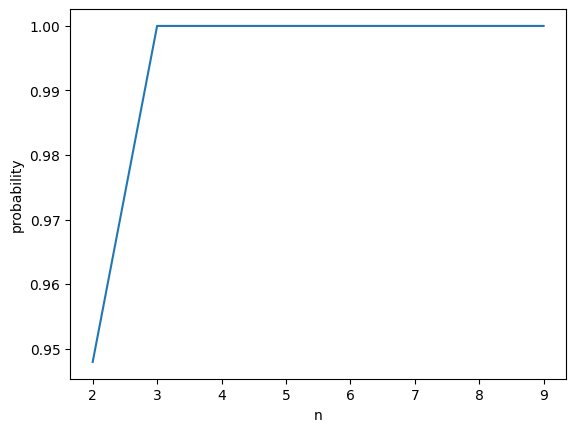

In [47]:
plt.plot(res.groupby('n')['res'].agg(np.average))
plt.xlabel('n')
plt.ylabel('probability')
plt.show()

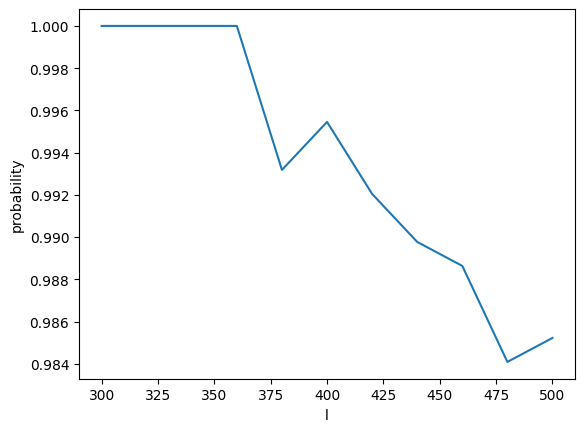

In [48]:
plt.plot(res.groupby('l')['res'].agg(np.average))
plt.xlabel('l')
plt.ylabel('probability')
plt.show()

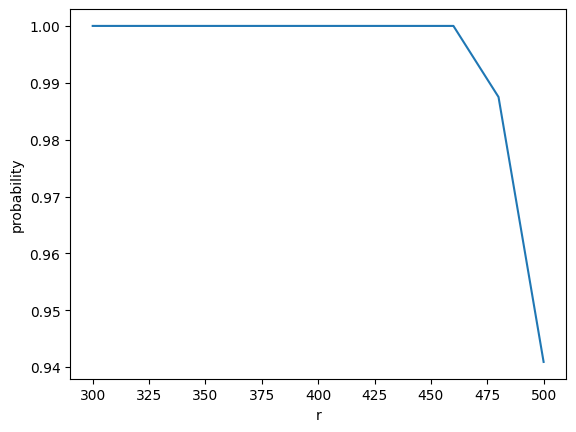

In [49]:
plt.plot(res.groupby('r')['res'].agg(np.average))
plt.xlabel('r')
plt.ylabel('probability')
plt.show()